(GLM-simpsons-paradox)=
# Simpson's paradox and mixed models

:::{post} September, 2024
:tags: regression, hierarchical model, linear model, posterior predictive, Simpson's paradox 
:category: beginner
:author: Benjamin T. Vincent
:::

[Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox) describes a situation where there might be a negative relationship between two variables within a group, but when data from multiple groups are combined, that relationship may disappear or even reverse sign. The gif below (from the [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox) Wikipedia page) demonstrates this very nicely.

![](https://upload.wikimedia.org/wikipedia/commons/f/fb/Simpsons_paradox_-_animation.gif)

This paradox can be resolved by assuming a causal DAG which includes how the main predictor variable _and_ group membership influence the outcome variable. We demonstrate an example where we _don't_ incorporate group membership (so our causal DAG is wrong, or in other words out model is misspecified). We then show 2 wayes to resolve this by including group membership as causal influence upon the outcome variable. This is shown in an unpooled model (which we could also call a fixed effects model) and a hierarchical model (which we could also call a mixed effects model).

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## Generate data

This data generation was influenced by this [stackexchange](https://stats.stackexchange.com/questions/479201/understanding-simpsons-paradox-with-random-effects) question.

In [3]:
def generate():
    group_list = ["one", "two", "three", "four", "five"]
    trials_per_group = 20
    group_intercepts = rng.normal(0, 1, len(group_list))
    group_slopes = np.ones(len(group_list)) * -0.5
    group_mx = group_intercepts * 2
    group = np.repeat(group_list, trials_per_group)
    subject = np.concatenate(
        [np.ones(trials_per_group) * i for i in np.arange(len(group_list))]
    ).astype(int)
    intercept = np.repeat(group_intercepts, trials_per_group)
    slope = np.repeat(group_slopes, trials_per_group)
    mx = np.repeat(group_mx, trials_per_group)
    x = rng.normal(mx, 1)
    y = rng.normal(intercept + (x - mx) * slope, 1)
    data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})
    return data, group_list

In [4]:
data, group_list = generate()

To follow along, it is useful to clearly understand the form of the data. This is [long form](https://en.wikipedia.org/wiki/Wide_and_narrow_data) data (also known as narrow data) in that each row represents one observation. We have a `group` column which has the group label, and an accompanying numerical `group_idx` column. This is very useful when it comes to modelling as we can use it as an index to look up group-level parameter estimates. Finally, we have our core observations of the predictor variable `x` and the outcome `y`.

In [5]:
display(data)

group  group_idx         x         y
0    one          0 -0.294574 -2.338519
1    one          0 -4.686497 -1.448057
2    one          0 -2.262201 -1.393728
3    one          0 -4.873809 -0.265403
4    one          0 -2.863929 -0.774251
..   ...        ...       ...       ...
95  five          4  3.981413  0.467970
96  five          4  1.889102  0.553290
97  five          4  2.561267  2.590966
98  five          4  0.147378  2.050944
99  five          4  2.738073  0.517918

[100 rows x 4 columns]

And we can visualise this as below.

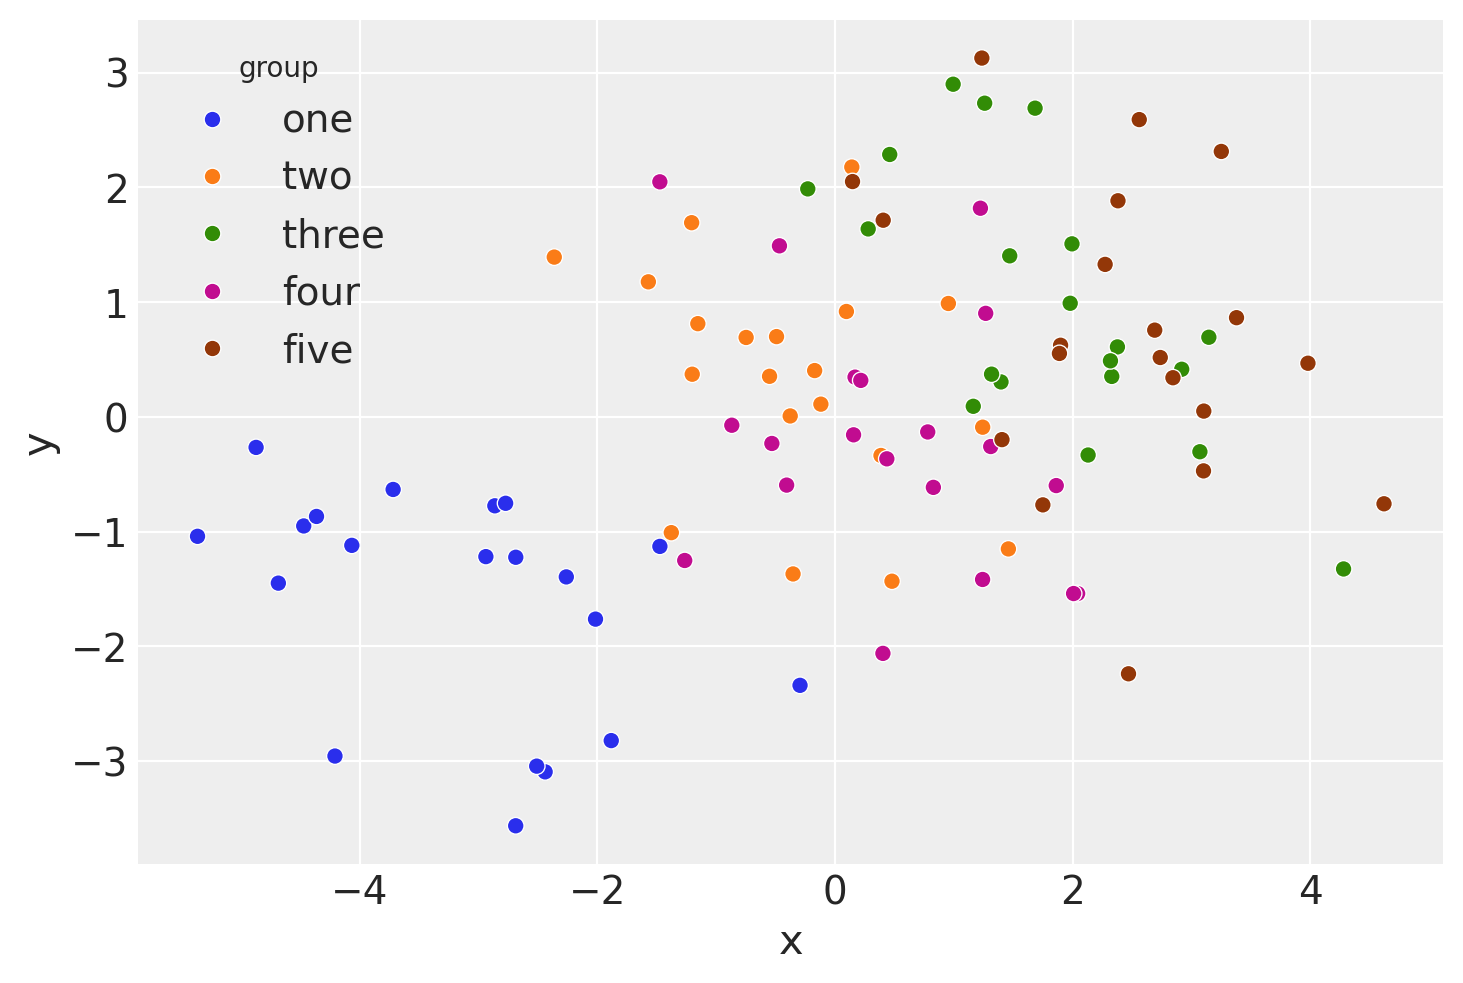

In [6]:
sns.scatterplot(data=data, x="x", y="y", hue="group");

The rest of the notebook will cover different ways that we can analyse this data using linear models.

## Model 1: Pooled regression

First we examine the simplest model - plain linear regression which pools all the data and has no knowledge of the group/multi-level structure of the data.

From a causal perspective, this approach embodies the belief that $x$ causes $y$ and that this relationship is constant across all groups, or groups are simply not considered. This can be shown in the causal DAG below.

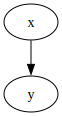

In [7]:
g = gr.Digraph()
g.node(name="x", label="x")
g.node(name="y", label="y")
g.edge(tail_name="x", head_name="y")
g

We could describe this model mathematically as:

$$
\begin{aligned}
\beta_0, \beta_1 &\sim \text{Normal}(0, 5) \\
\sigma &\sim \text{Gamma}(2, 2) \\
\mu_i &= \beta_0 + \beta_1 x_i \\
y_i &\sim \text{Normal}(\mu_i, \sigma)
\end{aligned}
$$

### Build model

In [8]:
with pm.Model() as model1:
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
    sigma = pm.Gamma("sigma", 2, 2)
    x = pm.Data("x", data.x, dims="obs_id")
    μ = pm.Deterministic("μ", β0 + β1 * x, dims="obs_id")
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

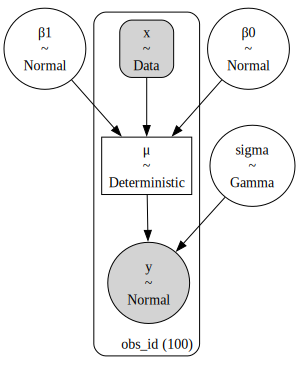

In [9]:
pm.model_to_graphviz(model1)

### Do inference

In [10]:
with model1:
    idata1 = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


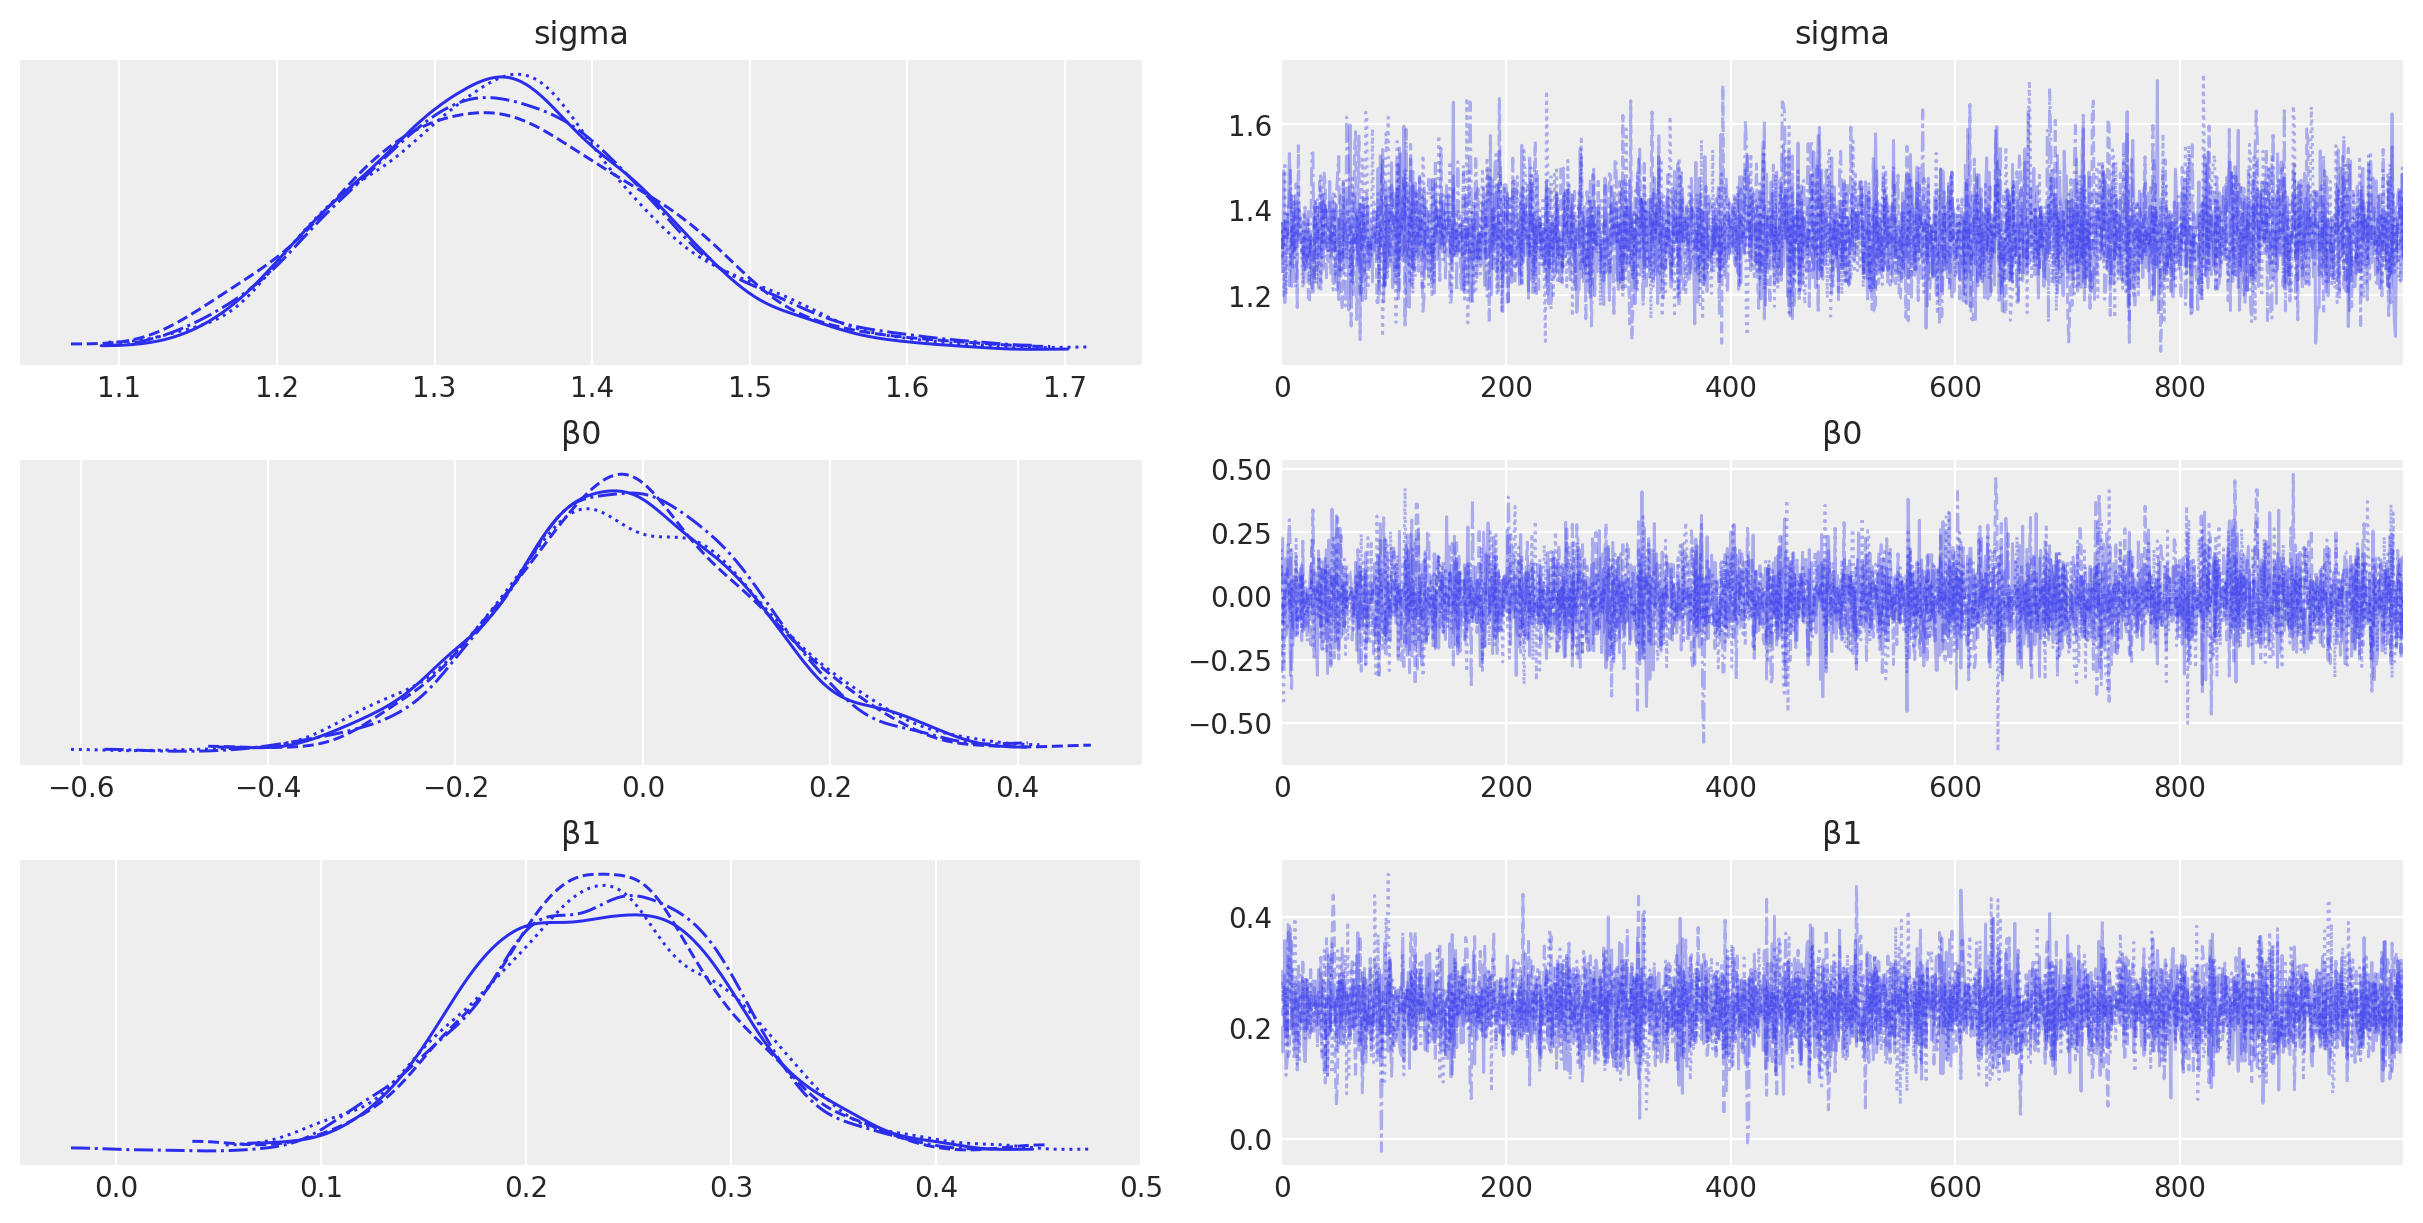

In [11]:
az.plot_trace(idata1, var_names=["~μ"]);

### Visualisation

First we'll define a handy predict function which will do out of sample predictions for us. This will be handy when it comes to visualising the model fit.

In [12]:
def predict(model: pm.Model, idata: az.InferenceData, predict_at: dict) -> az.InferenceData:
    """Do posterior predictive inference"""
    with model:
        pm.set_data(predict_at)
        idata.extend(pm.sample_posterior_predictive(idata, var_names=["y", "μ"], random_seed=rng))
    return idata

In [13]:
idata1 = predict(
    model=model1,
    idata=idata1,
    predict_at={"x": np.linspace(data.x.min(), data.x.max(), 20)},
)

Sampling: [y]


Output()

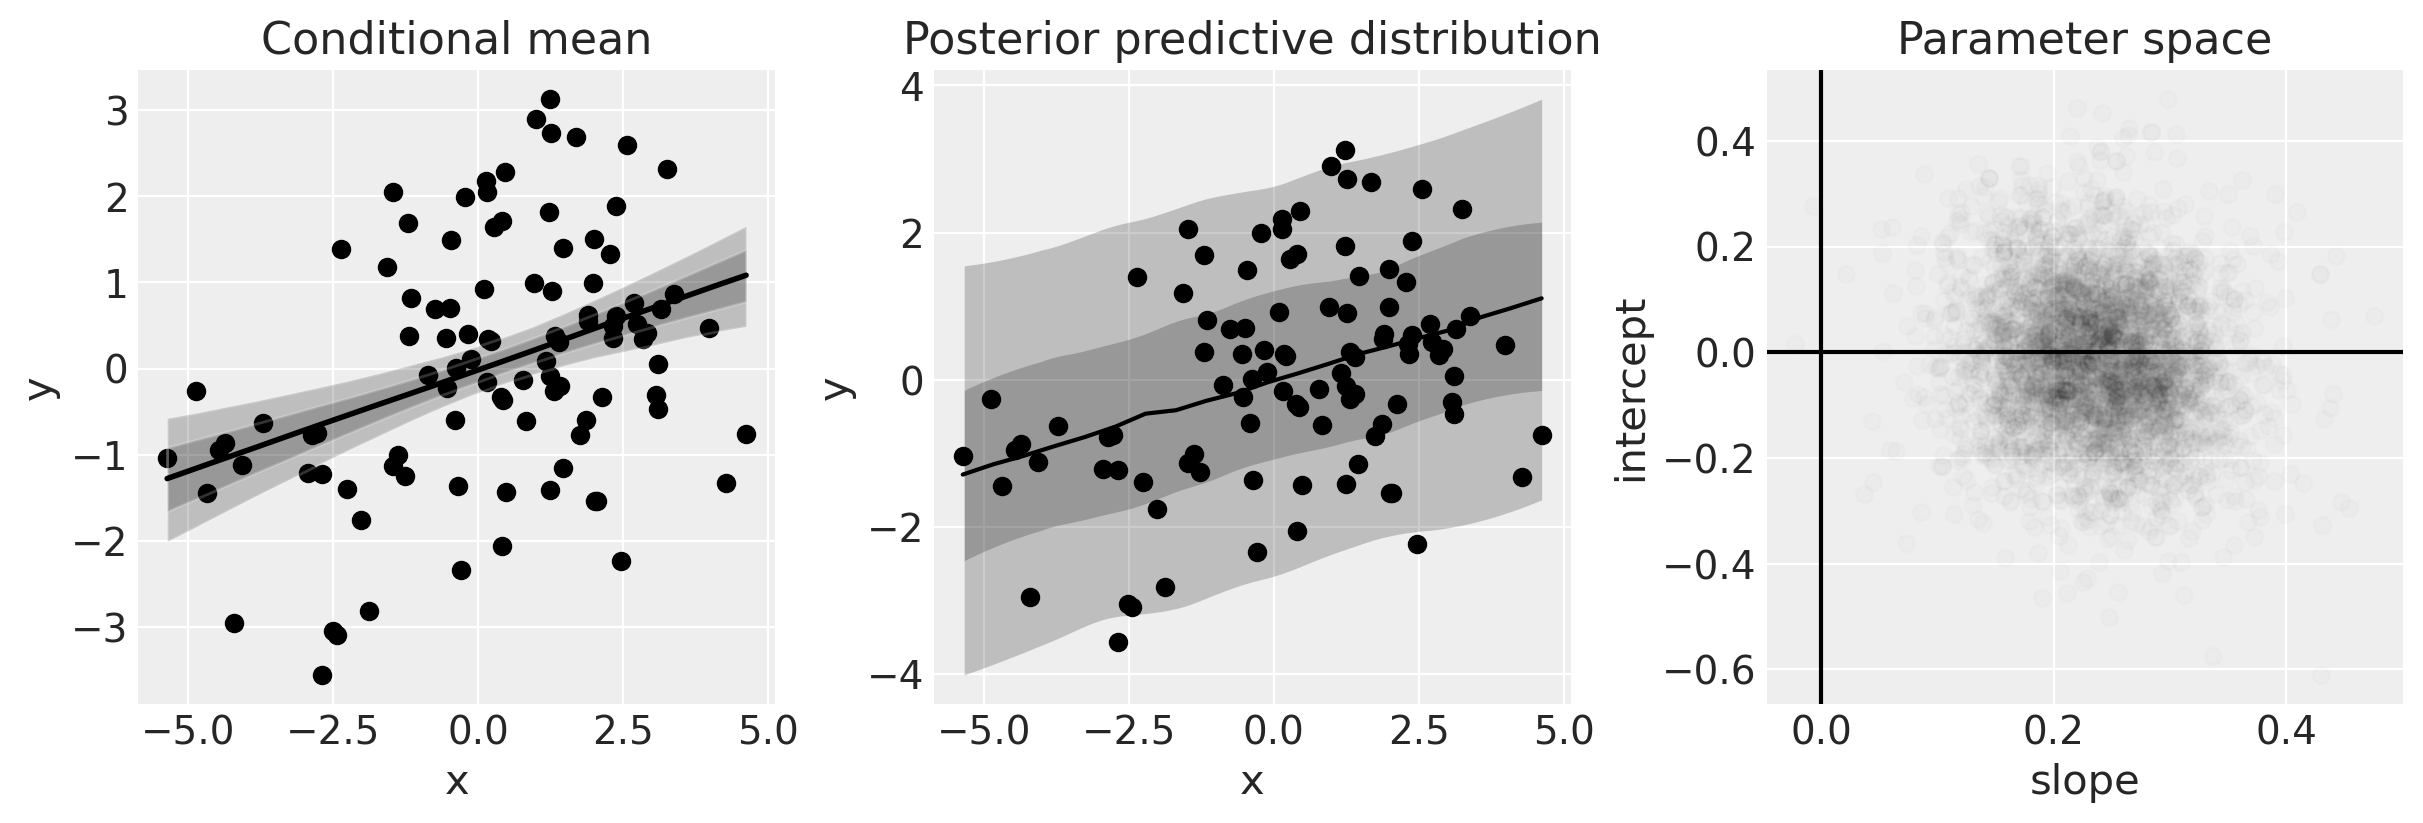

In [14]:
def plot(idata):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # conditional mean plot ---------------------------------------------
    # data
    ax[0].scatter(data.x, data.y, color="k")
    # conditional mean credible intervals
    post = az.extract(idata)
    xi = xr.DataArray(np.linspace(np.min(data.x), np.max(data.x), 20), dims=["x_plot"])
    y = post.β0 + post.β1 * xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax[0].fill_between(
        xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color="k",
        edgecolor="w",
    )
    ax[0].fill_between(
        xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color="k",
        edgecolor="w",
    )
    # conditional mean
    ax[0].plot(xi, region.sel(quantile=0.5), "k", linewidth=2)
    # formatting
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

    # posterior prediction ----------------------------------------------
    # data
    ax[1].scatter(data.x, data.y, color="k")
    # posterior mean and HDI's

    ax[1].plot(xi, idata.posterior_predictive.y.mean(["chain", "draw"]), "k")

    az.plot_hdi(
        xi,
        idata.posterior_predictive.y,
        hdi_prob=0.6,
        color="k",
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax[1],
    )
    az.plot_hdi(
        xi,
        idata.posterior_predictive.y,
        hdi_prob=0.95,
        color="k",
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax[1],
    )
    # formatting
    ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")

    # parameter space ---------------------------------------------------
    ax[2].scatter(
        az.extract(idata, var_names=["β1"]),
        az.extract(idata, var_names=["β0"]),
        color="k",
        alpha=0.01,
        rasterized=True,
    )

    # formatting
    ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")
    ax[2].axhline(y=0, c="k")
    ax[2].axvline(x=0, c="k")


plot(idata1)

The plot on the left shows the data and the posterior of the **conditional mean**. For a given $x$, we get a posterior distribution of the model (i.e. of $\mu$).

The plot in the middle shows the **posterior predictive distribution**, which gives a statement about the data we expect to see. Intuitively, this can be understood as not only incorporating what we know of the model (left plot) but also what we know about the distribution of error.

The plot on the right shows out posterior beliefs in **parameter space**.

One of the clear things about this analysis is that we have credible evidence that $x$ and $y$ are _positively_ correlated. We can see this from the posterior over the slope (see right hand panel in the figure above).

## Model 2: Unpooled regression

We will use the same data in this analysis, but this time we will use our knowledge that data come from groups. From a causal perspective we are exploring the notion that both $x$ and $y$ are influenced by group membership. This can be shown in the causal DAG below.


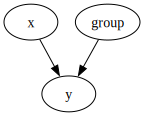

In [15]:
g = gr.Digraph()
g.node(name="x", label="x")
g.node(name="g", label="group")
g.node(name="y", label="y")
g.edge(tail_name="x", head_name="y")
g.edge(tail_name="g", head_name="y")
g

More specifically we will essentially fit independent regressions to data within each group. This could also be described as an unpooled model. We could describe this model mathematically as:

$$
\begin{aligned}
\vec{\beta_0}, \vec{\beta_1} &\sim \text{Normal}(0, 5) \\
\sigma &\sim \text{Gamma}(2, 2) \\
\mu_i &= \beta_0[g_i] + \beta_1[g_i] x_i \\
y_i &\sim \text{Normal}(\mu_i, g_i)
\end{aligned}
$$

Where $g_i$ is the group index for observation $i$. So the parameters $\beta_0$ and $\beta_1$ are now length $g$ vectors, not scalars. And the $[g_i]$ acts as an index to look up the group for the $i^{\th}$ observation.

In [16]:
coords = {"group": group_list}

with pm.Model(coords=coords) as model2:
    # Define priors
    β0 = pm.Normal("β0", 0, sigma=5, dims="group")
    β1 = pm.Normal("β1", 0, sigma=5, dims="group")
    sigma = pm.Gamma("sigma", 2, 2)
    # Data
    x = pm.Data("x", data.x, dims="obs_id")
    g = pm.Data("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

By plotting the DAG for this model it is clear to see that we now have individual intercept, slope, and variance parameters for each of the groups.

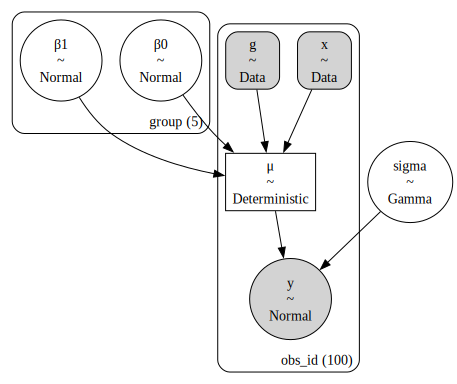

In [17]:
pm.model_to_graphviz(model2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


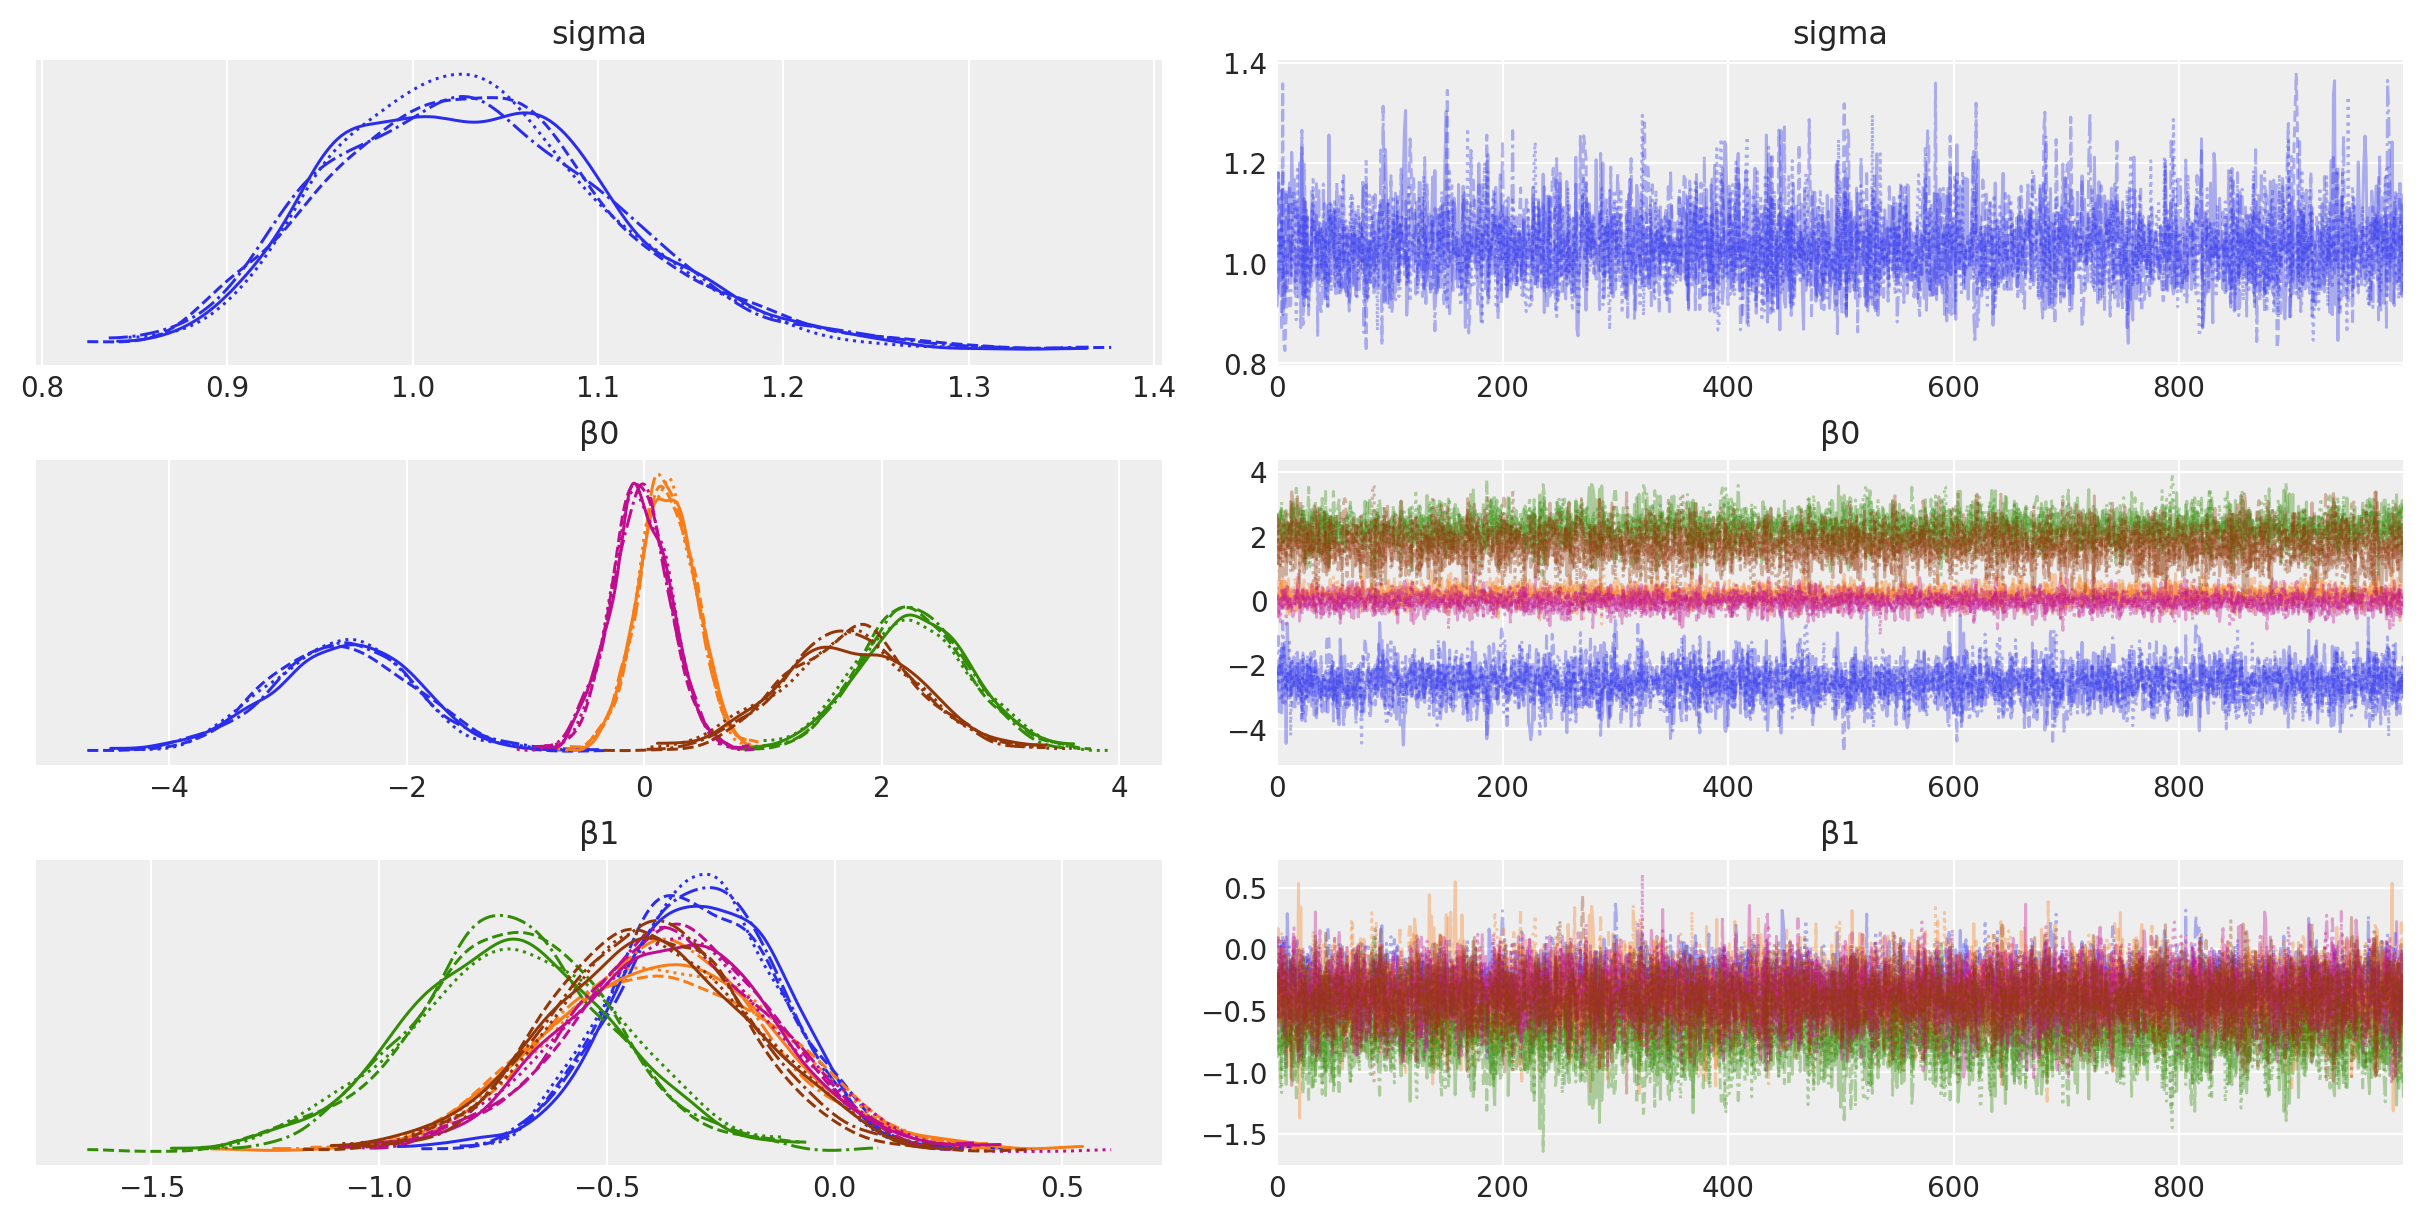

In [18]:
with model2:
    idata2 = pm.sample(random_seed=rng)

az.plot_trace(idata2, var_names=["~μ"]);

### Visualisation

In [19]:
# Generate values of xi and g for posterior prediction
n_points = 10
n_groups = len(data.group.unique())
xi = np.concatenate(
    [
        np.linspace(group[1].x.min(), group[1].x.max(), n_points)
        for group in data.groupby("group_idx")
    ]
)
g = np.concatenate([[i] * n_points for i in range(n_groups)]).astype(int)
predict_at = {"x": xi, "g": g}

In [20]:
idata2 = predict(
    model=model2,
    idata=idata2,
    predict_at=predict_at,
)

Sampling: [y]


Output()

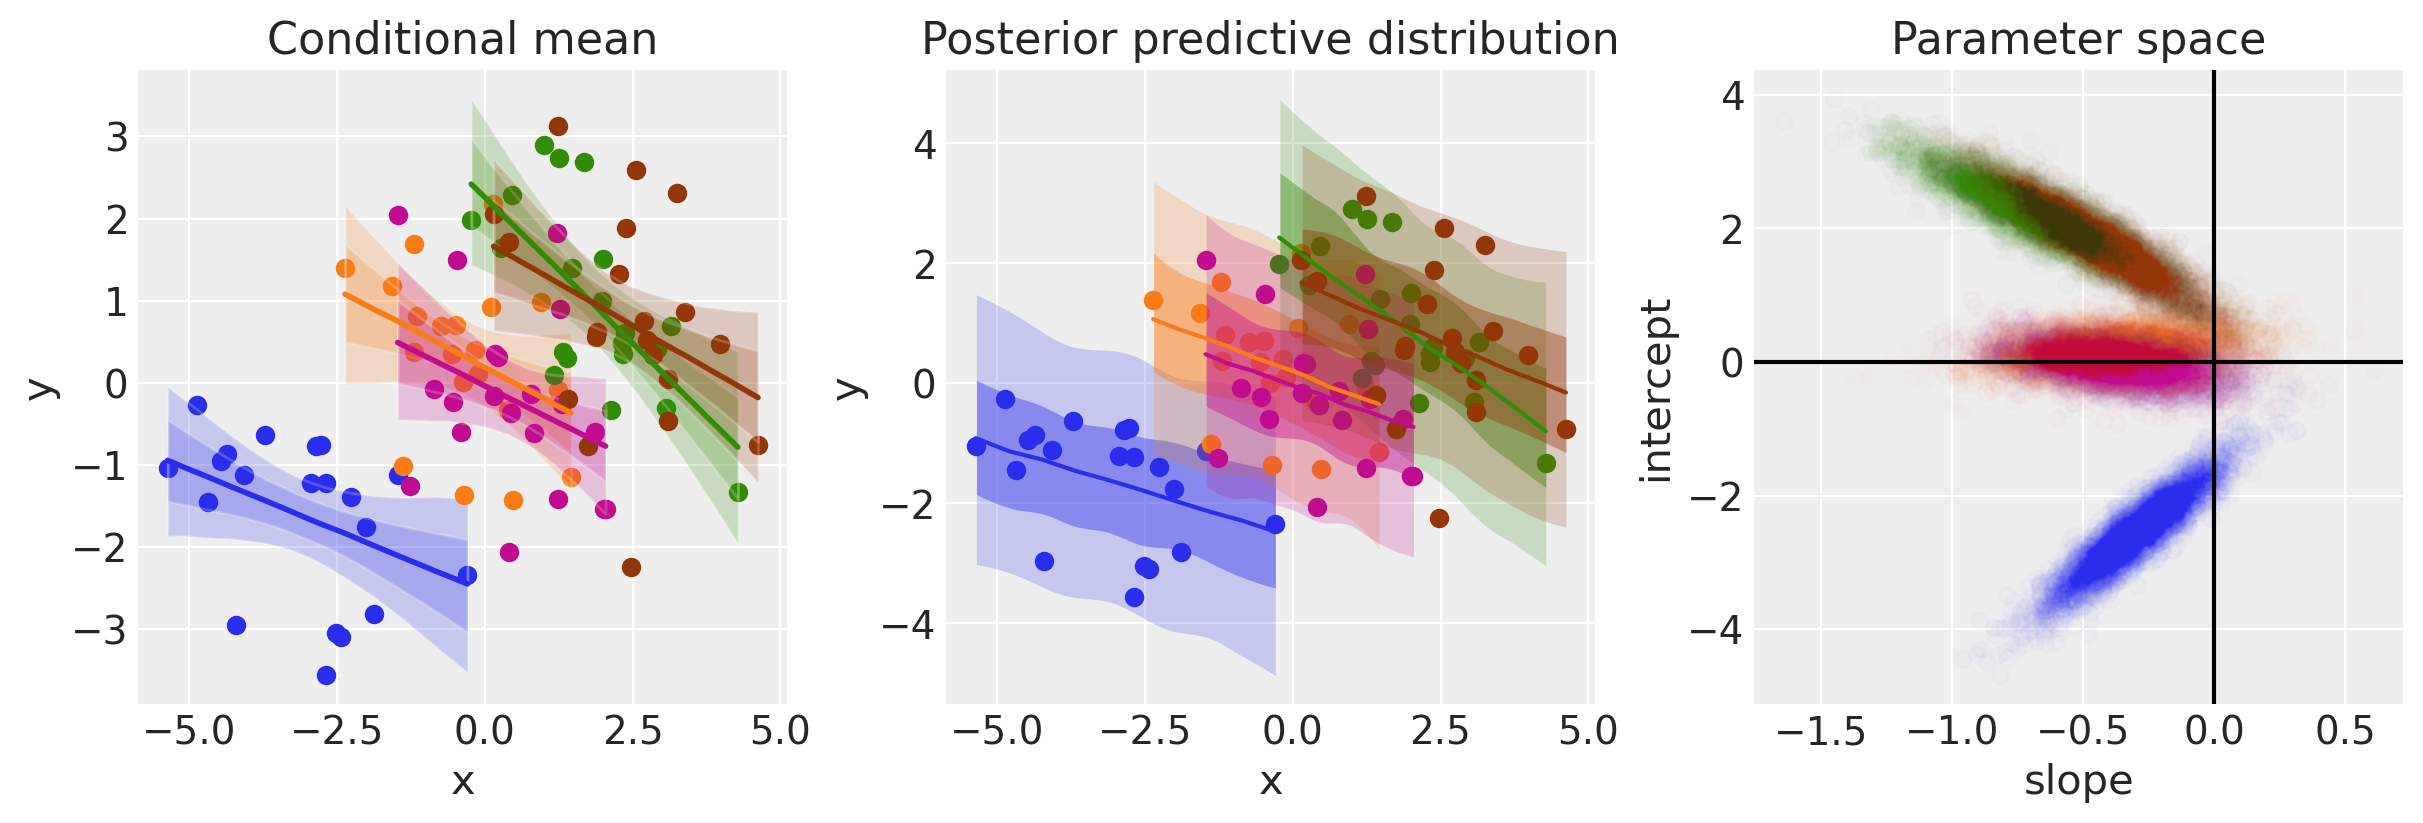

In [21]:
def get_ppy_for_group(idata, group_list, group):
    """Get posterior predictive outcomes for observations from a given group"""
    return idata.posterior_predictive.y.data[:, :, group_list == group]


def plot(idata):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # conditional mean plot ---------------------------------------------
    for i, groupname in enumerate(group_list):
        # data
        ax[0].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
        # conditional mean credible intervals
        post = az.extract(idata)
        _xi = xr.DataArray(
            np.linspace(
                np.min(data.x[data.group_idx == i]),
                np.max(data.x[data.group_idx == i]),
                20,
            ),
            dims=["x_plot"],
        )
        y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
        region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
        ax[0].fill_between(
            _xi,
            region.sel(quantile=0.025),
            region.sel(quantile=0.975),
            alpha=0.2,
            color=f"C{i}",
            edgecolor="w",
        )
        ax[0].fill_between(
            _xi,
            region.sel(quantile=0.15),
            region.sel(quantile=0.85),
            alpha=0.2,
            color=f"C{i}",
            edgecolor="w",
        )
        # conditional mean
        ax[0].plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
        # formatting
        ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

    # posterior prediction ----------------------------------------------
    for i, groupname in enumerate(group_list):
        # data
        ax[1].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
        # posterior mean and HDI's
        ax[1].plot(
            xi[g == i],
            np.mean(get_ppy_for_group(idata, g, i), axis=(0, 1)),
            label=groupname,
        )
        az.plot_hdi(
            xi[g == i],
            get_ppy_for_group(idata, g, i),  # pp_y[:, :, g == i],
            hdi_prob=0.6,
            color=f"C{i}",
            fill_kwargs={"alpha": 0.4, "linewidth": 0},
            ax=ax[1],
        )
        az.plot_hdi(
            xi[g == i],
            get_ppy_for_group(idata, g, i),
            hdi_prob=0.95,
            color=f"C{i}",
            fill_kwargs={"alpha": 0.2, "linewidth": 0},
            ax=ax[1],
        )

    ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")

    # parameter space ---------------------------------------------------
    for i, _ in enumerate(group_list):
        ax[2].scatter(
            az.extract(idata, var_names="β1")[i, :],
            az.extract(idata, var_names="β0")[i, :],
            color=f"C{i}",
            alpha=0.01,
            rasterized=True,
        )

    ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")
    ax[2].axhline(y=0, c="k")
    ax[2].axvline(x=0, c="k")


plot(idata2)

In contrast to plain regression model (Model 1), when we model on the group level we can see that now the evidence points toward _negative_ relationships between $x$ and $y$.

## Model 3: Partial pooling (hierarchical) model

Model 3 assumes the same causal DAG as model 2 (see above). However, we can go further and incorporate more knowledge about the structure of our data. Rather than treating each group as entirely independent, we can use our knowledge that these groups are drawn from a population-level distribution. 

And we could describe this model mathematically as:

$$
\begin{aligned}
p_{0\mu}, p_{1\mu} &= \text{Normal}(0, 1) \\
p_{0\sigma}, p_{1\sigma} &= \text{Gamma}(2, 2) \\
\vec{\beta_0} &\sim \text{Normal}(p_{0\mu}, p_{0\sigma}) \\
\vec{\beta_1} &\sim \text{Normal}(p_{1\mu}, p_{1\sigma}) \\
\sigma &\sim \text{Gamma}(2, 2) \\
\mu_i &= \beta_0[g_i] +  \beta_1[g_i] \cdot x_i \\
y_i &\sim \text{Normal}(\mu_i, \sigma)
\end{aligned}
$$

where $\beta_0$ and $\beta_1$ are the population-level parameters, and $\gamma_0$ and $\gamma_1$ are the group offset parameters.

This model could also be called a partial pooling model. 

:::{note}
The hierarchical model we are considering contains a simplification in that the population level slope and intercept are assumed to be independent. It is possible to relax this assumption and model any correlation between these parameters by using a multivariate normal distribution.

In one sense this move from Model 2 to Model 3 can be seen as adding parameters, and therefore increasing model complexity. However, in another sense, adding this knowledge about the nested structure of the data actually provides a constraint over parameter space.
:::

In [22]:
non_centered = False

with pm.Model(coords=coords) as model3:
    # Define priors
    intercept_mu = pm.Normal("intercept_mu", 0, 1)
    slope_mu = pm.Normal("slope_mu", 0, 1)
    intercept_sigma = pm.Gamma("intercept_sigma", 2, 2)
    slope_sigma = pm.Gamma("slope_sigma", 2, 2)
    sigma = pm.Gamma("sigma", 2, 2)
    if non_centered:
        gamma_0 = pm.Normal("gamma_0", 0, 1, dims="group")
        β0 = pm.Deterministic("β0", intercept_mu + gamma_0 * intercept_sigma, dims="group")
        gamma_1_offset = pm.Normal("gamma_1_offset", 0, 1, dims="group")
        β1 = pm.Deterministic("β1", slope_mu + gamma_1_offset * slope_sigma, dims="group")
    else:
        β0 = pm.Normal("β0", intercept_mu, intercept_sigma, dims="group")
        β1 = pm.Normal("β1", slope_mu, slope_sigma, dims="group")

    # Sample from population level slope and intercepts for convenience
    pm.Normal("pop_intercept", intercept_mu, intercept_sigma)
    pm.Normal("pop_slope", slope_mu, slope_sigma)

    # Data
    x = pm.Data("x", data.x, dims="obs_id")
    g = pm.Data("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

Plotting the DAG now makes it clear that the group-level intercept and slope parameters are drawn from a population level distributions. That is, we have hyper-priors for the slopes and intercept parameters. This particular model does not have a hyper-prior for the measurement error - this is just left as one parameter per group, as in the previous model.

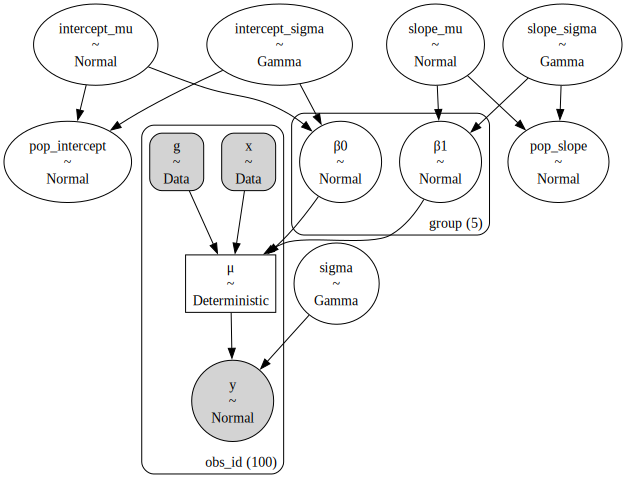

In [23]:
pm.model_to_graphviz(model3)

The nodes `pop_intercept` and `pop_slope` represent the population-level intercept and slope parameters. While the 5 $\beta_0$ and $\beta_1$ nodes represent intercepts and slopes for each of the 5 observed groups (respectively), the `pop_intercept` and `pop_slope` represent what we can infer about the population-level intercept and slope. Equivalently, we could say they represent our beliefs about an as yet unobserved group.

In [24]:
with model3:
    idata3 = pm.sample(tune=4000, target_accept=0.99, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, slope_mu, intercept_sigma, slope_sigma, sigma, β0, β1, pop_intercept, pop_slope]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 41 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


:::{caution}
Note that despite having a longer tune period and increased `target_accept`, this model can still generate a low number of divergent samples. If the reader is interested, you can explore the a "reparameterisation trick" is used by setting the flag `non_centered=True`. See the blog post [Why hierarchical models are awesome, tricky, and Bayesian](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) by Thomas Wiecki for more information on this.
:::

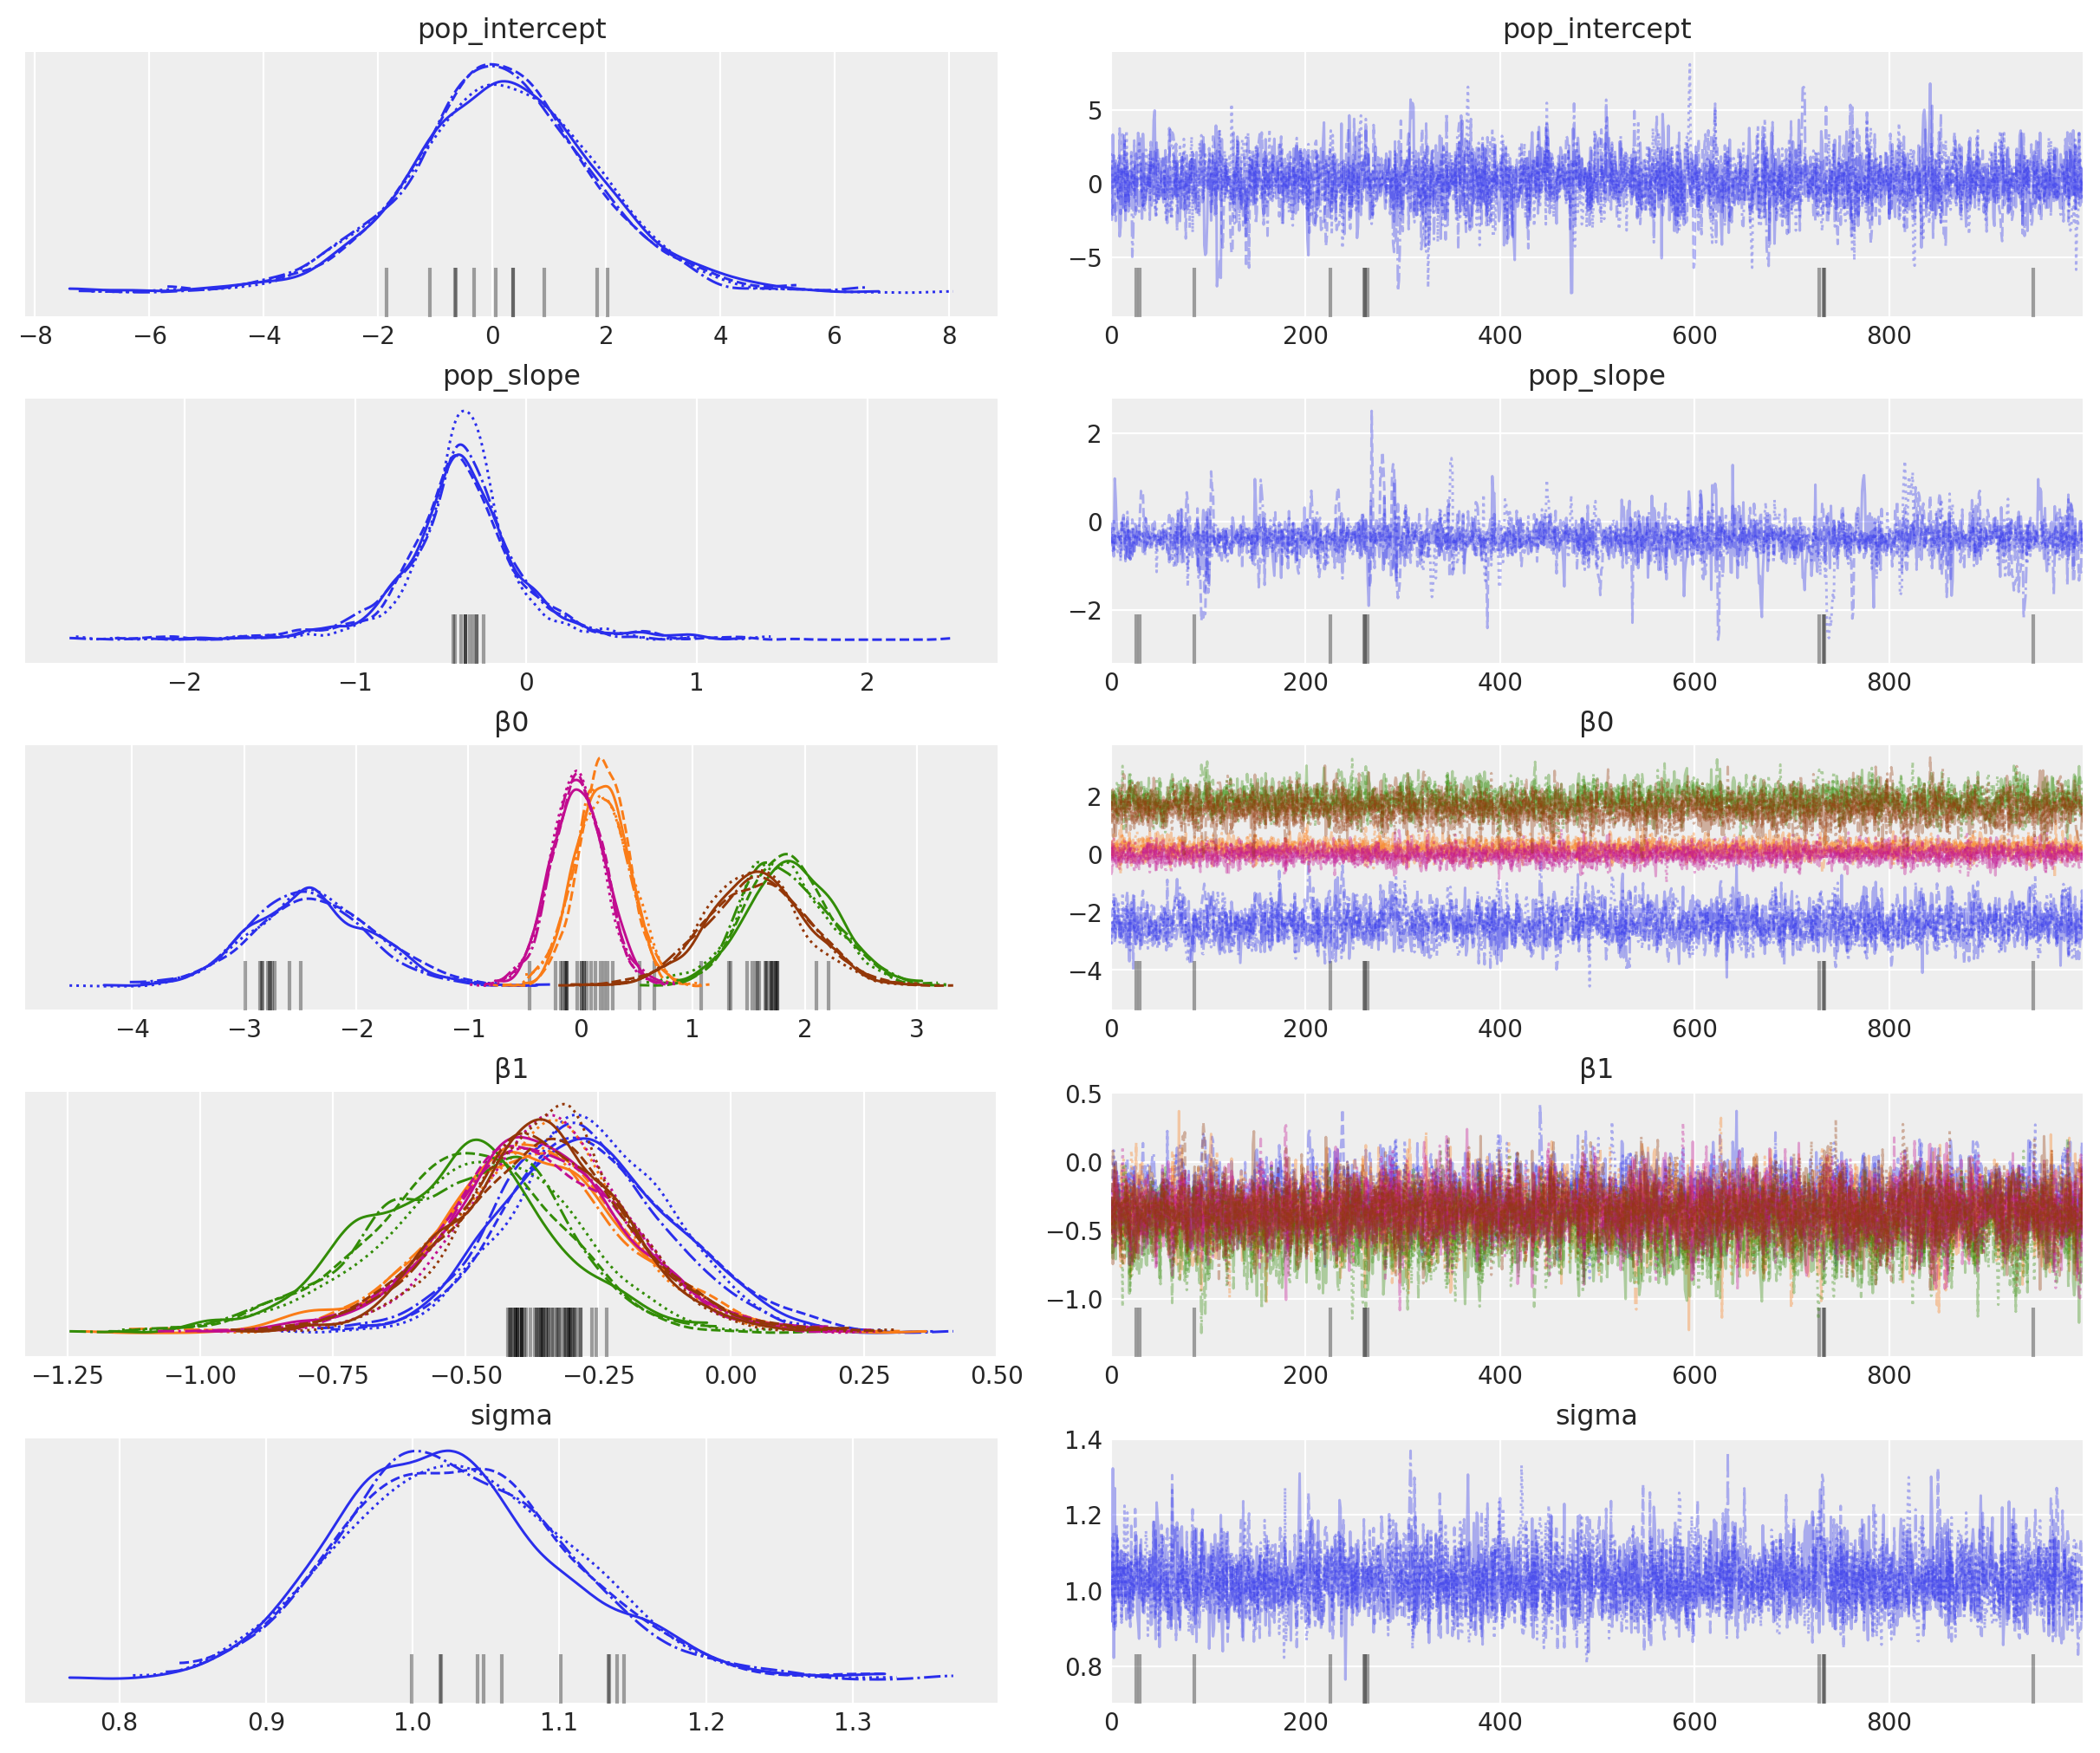

In [25]:
az.plot_trace(idata3, var_names=["pop_intercept", "pop_slope", "β0", "β1", "sigma"]);

### Visualise

In [26]:
# Generate values of xi and g for posterior prediction
n_points = 10
n_groups = len(data.group.unique())
xi = np.concatenate(
    [
        np.linspace(group[1].x.min(), group[1].x.max(), n_points)
        for group in data.groupby("group_idx")
    ]
)
g = np.concatenate([[i] * n_points for i in range(n_groups)]).astype(int)
predict_at = {"x": xi, "g": g}

idata3 = predict(
    model=model3,
    idata=idata3,
    predict_at=predict_at,
)

Sampling: [y]


Output()

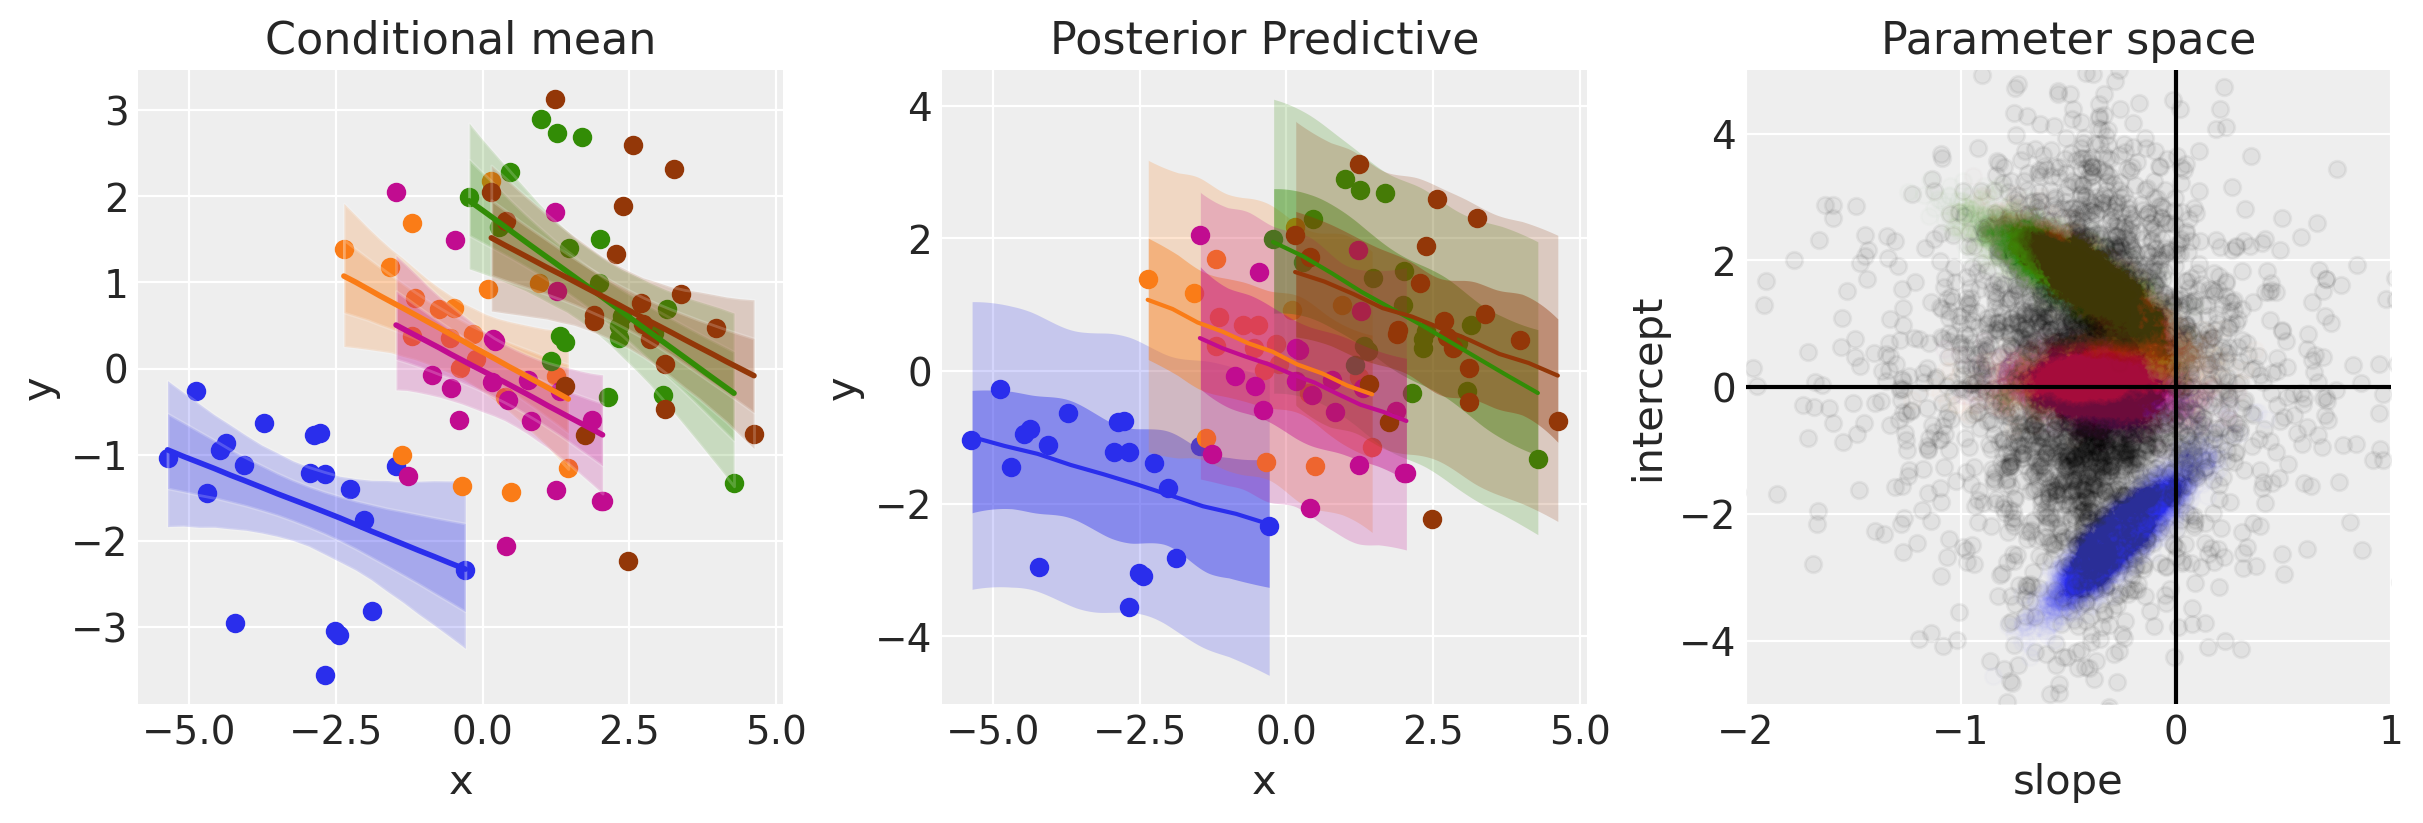

In [27]:
def plot(idata):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # conditional mean plot ---------------------------------------------
    for i, groupname in enumerate(group_list):
        # data
        ax[0].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
        # conditional mean credible intervals
        post = az.extract(idata)
        _xi = xr.DataArray(
            np.linspace(
                np.min(data.x[data.group_idx == i]),
                np.max(data.x[data.group_idx == i]),
                20,
            ),
            dims=["x_plot"],
        )
        y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
        region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
        ax[0].fill_between(
            _xi,
            region.sel(quantile=0.025),
            region.sel(quantile=0.975),
            alpha=0.2,
            color=f"C{i}",
            edgecolor="w",
        )
        ax[0].fill_between(
            _xi,
            region.sel(quantile=0.15),
            region.sel(quantile=0.85),
            alpha=0.2,
            color=f"C{i}",
            edgecolor="w",
        )
        # conditional mean
        ax[0].plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
        # formatting
        ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

    # posterior prediction ----------------------------------------------
    for i, groupname in enumerate(group_list):
        # data
        ax[1].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
        # posterior mean and HDI's
        ax[1].plot(
            xi[g == i],
            np.mean(get_ppy_for_group(idata, g, i), axis=(0, 1)),
            label=groupname,
        )
        az.plot_hdi(
            xi[g == i],
            get_ppy_for_group(idata, g, i),
            hdi_prob=0.6,
            color=f"C{i}",
            fill_kwargs={"alpha": 0.4, "linewidth": 0},
            ax=ax[1],
        )
        az.plot_hdi(
            xi[g == i],
            get_ppy_for_group(idata, g, i),
            hdi_prob=0.95,
            color=f"C{i}",
            fill_kwargs={"alpha": 0.2, "linewidth": 0},
            ax=ax[1],
        )

    ax[1].set(xlabel="x", ylabel="y", title="Posterior Predictive")

    # parameter space ---------------------------------------------------
    # plot posterior for population level slope and intercept
    ax[2].scatter(
        az.extract(idata, var_names="pop_slope"),
        az.extract(idata, var_names="pop_intercept"),
        color="k",
        alpha=0.05,
    )
    # plot posterior for group level slope and intercept
    for i, _ in enumerate(group_list):
        ax[2].scatter(
            az.extract(idata, var_names="β1")[i, :],
            az.extract(idata, var_names="β0")[i, :],
            color=f"C{i}",
            alpha=0.01,
        )

    ax[2].set(
        xlabel="slope",
        ylabel="intercept",
        title="Parameter space",
        xlim=[-2, 1],
        ylim=[-5, 5],
    )
    ax[2].axhline(y=0, c="k")
    ax[2].axvline(x=0, c="k")


plot(idata3)

The panel on the right shows the posterior group level posterior of the slope and intercept parameters in black. This particular visualisation is a little unclear however, so we can just plot the marginal distribution below to see how much belief we have in the slope being less than zero.

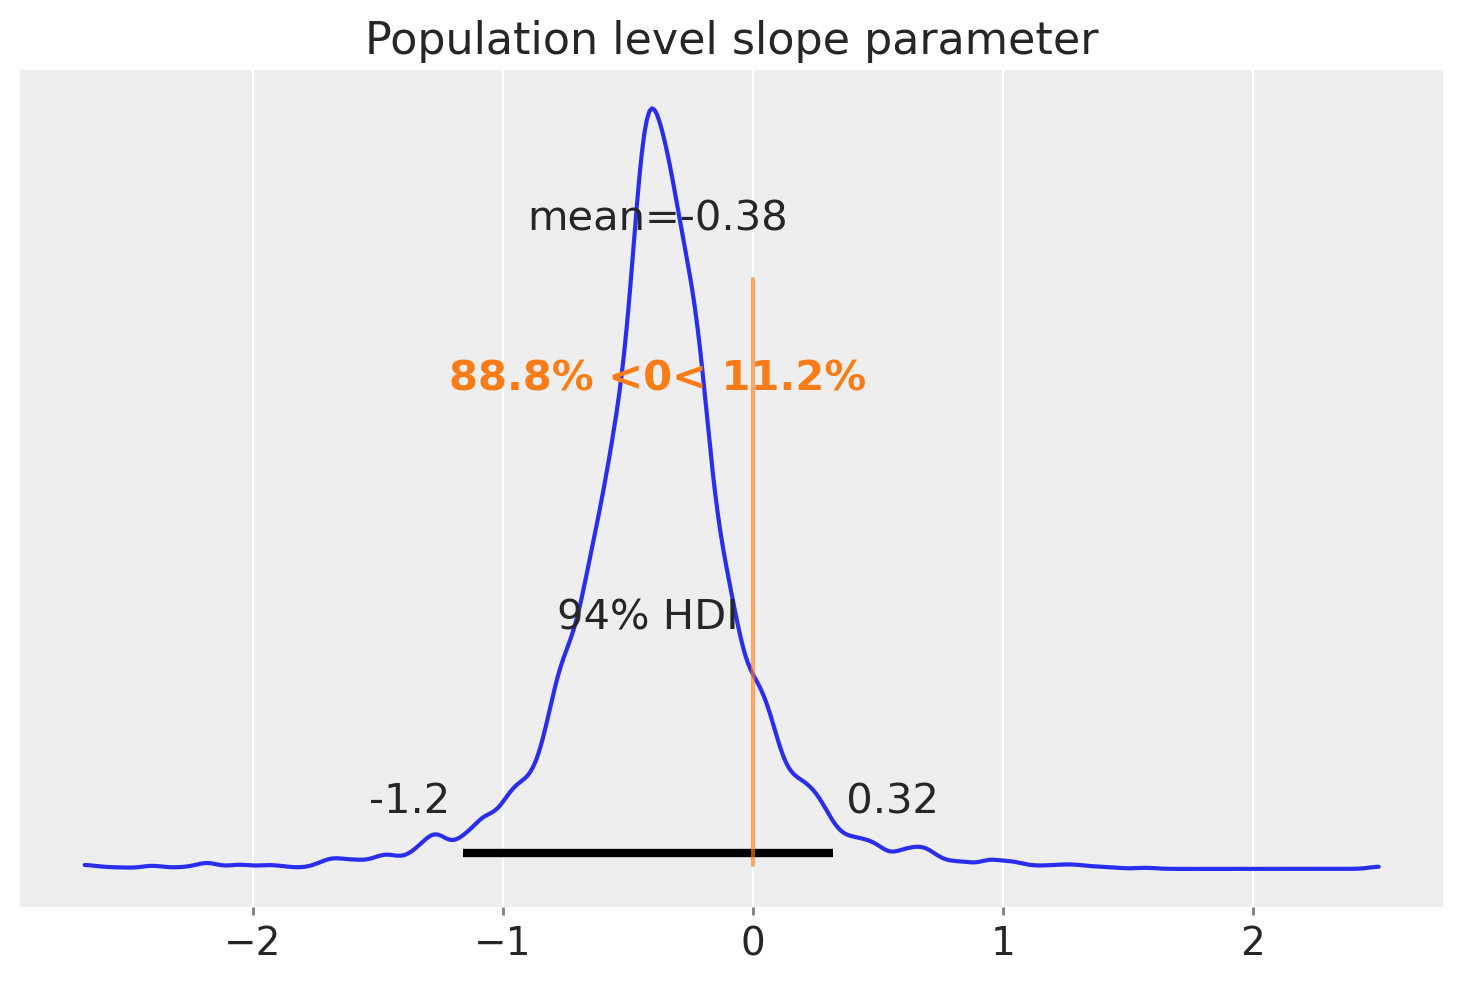

In [28]:
az.plot_posterior(idata3.posterior["pop_slope"], ref_val=0)
plt.title("Population level slope parameter");

## Summary
Using Simpson's paradox, we've walked through 3 different models. The first is a simple linear regression which treats all the data as coming from one group. This amounts to a causal DAG asserting that $x$ causally influences $y$ and $\text{group}$ was ignored (i.e. assumed to be causally unrelated to $x$ or $y$). We saw that this lead us to believe the regression slope was positive.

While that is not necessarily wrong, it is paradoxical when we see that the regression slopes for the data _within_ a group is negative. 

This paradox is resolved by updating our causal DAG to include the group variable. This is what we did in the second and third models. Model 2 was an unpooled model where we essentially fit separate regressions for each group.

Model 3 assumed the same causal DAG, but adds the knowledge that each of these groups are sampled from an overall population. This added the ability to make inferences not only about the regression parameters at the group level, but also at the population level.

If you are interested in learning more, there are a number of other [PyMC examples](http://docs.pymc.io/nb_examples/index.html) covering hierarchical modelling and regression topics.

## Authors
* Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in July 2021
* Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) in April 2022
* Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) in February 2023 to run on PyMC v5
* Updated to use `az.extract` by [Benjamin T. Vincent](https://github.com/drbenvincent) in February 2023 ([pymc-examples#522](https://github.com/pymc-devs/pymc-examples/pull/522))
* Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) in September 2024

## Watermark

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Sat Aug 31 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

pytensor: 2.22.1
xarray  : 2024.6.0

seaborn   : 0.13.2
pandas    : 2.2.2
matplotlib: 3.8.4
pymc      : 5.15.1
xarray    : 2024.6.0
arviz     : 0.18.0
graphviz  : 0.20.3
numpy     : 1.26.4

Watermark: 2.4.3



:::{include} ../page_footer.md
:::